In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_S5G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Mon Mar 22 03:48:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 66%   50C    P0    35W / 370W |      0MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 67%   

In [10]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/scpark/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [3]:
save_dir = 'save/model_S5G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json    save_430000  save_500000  save_570000  save_625000  save_685000
save_387320  save_435000  save_505000  save_575000  save_630000  save_690000
save_388173  save_440000  save_510000  save_580000  save_635000  save_695000
save_389704  save_445000  save_515000  save_585000  save_640000  save_700000
save_390000  save_450000  save_520000  save_590000  save_645000  save_700658
save_395000  save_455000  save_525000  save_595000  save_650000  save_701286
save_396617  save_460000  save_530000  save_600000  save_655000  save_705000
save_400000  save_465000  save_535000  save_601148  save_657369  save_710000
save_405000  save_470000  save_540000  save_603650  save_660000  save_710471
save_410000  save_475000  save_545000  save_605000  save_660616
save_415000  save_480000  save_550000  save_610000  save_665000
save_420000  save_485000  save_555000  save_614153  save_670000
save_421814  save_490000  save_560000  save_615000  save_675000
save_425000  save_495000  save_565000  save_620000 

In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 710471

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 283.0MiB
TTS size 195.3MiB
MelEncoder size 65.3MiB
MelDecoder size 119.0MiB
loaded : 710471
710471
done


In [6]:
trainset = LJDataset(tts_hparams, split='train')
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.03067784309387207


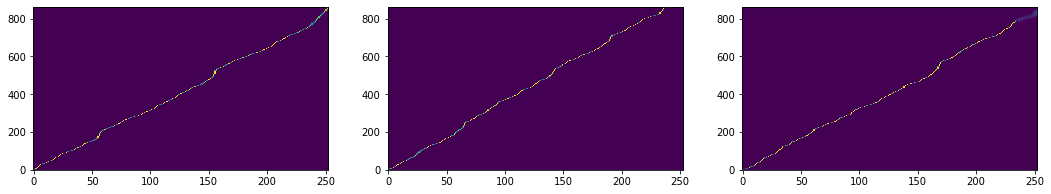

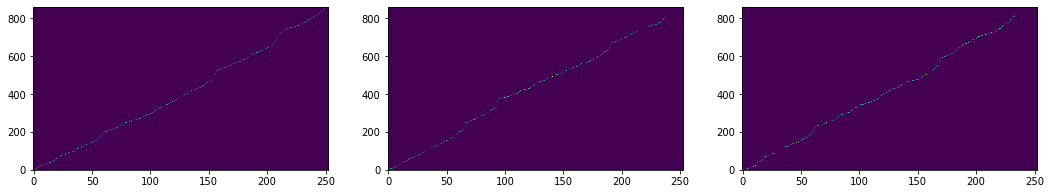

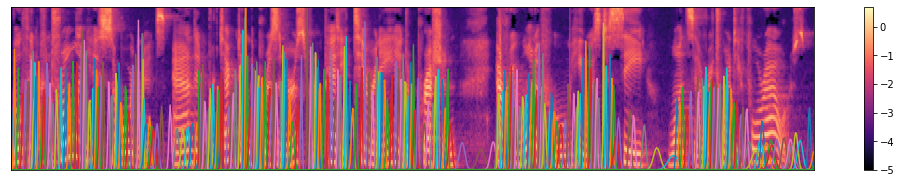

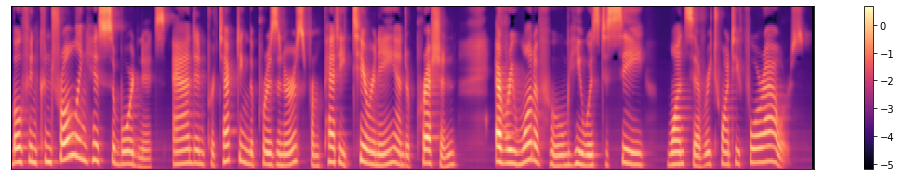

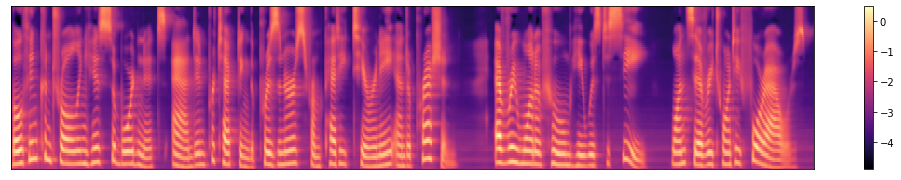

tensor(0.1735, device='cuda:0')
step : 712501 stt : 0.0016 tts : 0.1553 recon : 0.0214 kl : 0.0056 beta : 1.0000
tensor(0.1096, device='cuda:0')
step : 712502 stt : 0.0005 tts : 0.1164 recon : 0.0207 kl : 0.0054 beta : 1.0000
tensor(0.1218, device='cuda:0')
step : 712503 stt : 0.0002 tts : 0.1370 recon : 0.0227 kl : 0.0058 beta : 1.0000
tensor(0.1096, device='cuda:0')
step : 712504 stt : 0.0012 tts : 0.1293 recon : 0.0228 kl : 0.0059 beta : 1.0000
tensor(0.1095, device='cuda:0')
step : 712505 stt : 0.0003 tts : 0.1154 recon : 0.0206 kl : 0.0053 beta : 1.0000
tensor(0.1694, device='cuda:0')
step : 712506 stt : 0.0005 tts : 0.1268 recon : 0.0210 kl : 0.0053 beta : 1.0000
tensor(0.1266, device='cuda:0')
step : 712507 stt : 0.0003 tts : 0.1205 recon : 0.0207 kl : 0.0053 beta : 1.0000
tensor(0.0985, device='cuda:0')
step : 712508 stt : 0.0012 tts : 0.1262 recon : 0.0224 kl : 0.0057 beta : 1.0000
tensor(0.1126, device='cuda:0')
step : 712509 stt : 0.0004 tts : 0.1270 recon : 0.0235 kl : 0.00

tensor(0.1214, device='cuda:0')
step : 712574 stt : 0.0005 tts : 0.1220 recon : 0.0217 kl : 0.0057 beta : 1.0000
tensor(0.1378, device='cuda:0')
step : 712575 stt : 0.0005 tts : 0.1261 recon : 0.0218 kl : 0.0057 beta : 1.0000
tensor(0.2110, device='cuda:0')
step : 712576 stt : 0.0007 tts : 0.1399 recon : 0.0252 kl : 0.0062 beta : 1.0000
tensor(0.1206, device='cuda:0')
step : 712577 stt : 0.0004 tts : 0.1260 recon : 0.0210 kl : 0.0054 beta : 1.0000
tensor(0.1223, device='cuda:0')
step : 712578 stt : 0.0006 tts : 0.1324 recon : 0.0226 kl : 0.0058 beta : 1.0000
tensor(0.1098, device='cuda:0')
step : 712579 stt : 0.0002 tts : 0.1372 recon : 0.0224 kl : 0.0058 beta : 1.0000
tensor(0.1475, device='cuda:0')
step : 712580 stt : 0.0003 tts : 0.1260 recon : 0.0214 kl : 0.0055 beta : 1.0000
tensor(0.1494, device='cuda:0')
step : 712581 stt : 0.0009 tts : 0.1308 recon : 0.0241 kl : 0.0061 beta : 1.0000
tensor(0.0997, device='cuda:0')
step : 712582 stt : 0.0003 tts : 0.1239 recon : 0.0220 kl : 0.00

tensor(0.1603, device='cuda:0')
step : 712647 stt : 0.0004 tts : 0.1319 recon : 0.0236 kl : 0.0061 beta : 1.0000
tensor(0.1221, device='cuda:0')
step : 712648 stt : 0.0004 tts : 0.1284 recon : 0.0225 kl : 0.0058 beta : 1.0000
tensor(0.1351, device='cuda:0')
step : 712649 stt : 0.0004 tts : 0.1313 recon : 0.0242 kl : 0.0062 beta : 1.0000
tensor(0.1307, device='cuda:0')
step : 712650 stt : 0.0009 tts : 0.1327 recon : 0.0255 kl : 0.0064 beta : 1.0000
tensor(0.1576, device='cuda:0')
step : 712651 stt : 0.0006 tts : 0.1291 recon : 0.0228 kl : 0.0057 beta : 1.0000
tensor(0.1151, device='cuda:0')
step : 712652 stt : 0.0003 tts : 0.1169 recon : 0.0206 kl : 0.0053 beta : 1.0000
tensor(0.1317, device='cuda:0')
step : 712653 stt : 0.0009 tts : 0.1290 recon : 0.0225 kl : 0.0058 beta : 1.0000
tensor(0.1254, device='cuda:0')
step : 712654 stt : 0.0007 tts : 0.1264 recon : 0.0220 kl : 0.0057 beta : 1.0000
tensor(0.1204, device='cuda:0')
step : 712655 stt : 0.0003 tts : 0.1266 recon : 0.0223 kl : 0.00

tensor(0.1396, device='cuda:0')
step : 712720 stt : 0.0009 tts : 0.1377 recon : 0.0264 kl : 0.0065 beta : 1.0000
tensor(0.1089, device='cuda:0')
step : 712721 stt : 0.0007 tts : 0.1364 recon : 0.0247 kl : 0.0063 beta : 1.0000
tensor(0.1166, device='cuda:0')
step : 712722 stt : 0.0007 tts : 0.1318 recon : 0.0270 kl : 0.0066 beta : 1.0000
tensor(0.1029, device='cuda:0')
step : 712723 stt : 0.0003 tts : 0.1206 recon : 0.0216 kl : 0.0055 beta : 1.0000
tensor(0.1265, device='cuda:0')
step : 712724 stt : 0.0006 tts : 0.1302 recon : 0.0236 kl : 0.0061 beta : 1.0000
tensor(0.1278, device='cuda:0')
step : 712725 stt : 0.0004 tts : 0.1338 recon : 0.0218 kl : 0.0056 beta : 1.0000
tensor(0.1086, device='cuda:0')
step : 712726 stt : 0.0003 tts : 0.1186 recon : 0.0225 kl : 0.0058 beta : 1.0000
tensor(0.1288, device='cuda:0')
step : 712727 stt : 0.0004 tts : 0.1281 recon : 0.0231 kl : 0.0059 beta : 1.0000
tensor(0.0953, device='cuda:0')
step : 712728 stt : 0.0005 tts : 0.1296 recon : 0.0235 kl : 0.00

tensor(0.1558, device='cuda:0')
step : 712793 stt : 0.0007 tts : 0.1281 recon : 0.0230 kl : 0.0059 beta : 1.0000
tensor(0.1231, device='cuda:0')
step : 712794 stt : 0.0003 tts : 0.1303 recon : 0.0234 kl : 0.0059 beta : 1.0000
tensor(0.1397, device='cuda:0')
step : 712795 stt : 0.0004 tts : 0.1387 recon : 0.0251 kl : 0.0063 beta : 1.0000
tensor(0.1144, device='cuda:0')
step : 712796 stt : 0.0010 tts : 0.1262 recon : 0.0224 kl : 0.0057 beta : 1.0000
tensor(0.1030, device='cuda:0')
step : 712797 stt : 0.0007 tts : 0.1251 recon : 0.0216 kl : 0.0056 beta : 1.0000
tensor(0.1126, device='cuda:0')
step : 712798 stt : 0.0004 tts : 0.1352 recon : 0.0238 kl : 0.0059 beta : 1.0000
tensor(0.1037, device='cuda:0')
step : 712799 stt : 0.0003 tts : 0.1257 recon : 0.0225 kl : 0.0058 beta : 1.0000
tensor(0.1240, device='cuda:0')
step : 712800 stt : 0.0004 tts : 0.1259 recon : 0.0236 kl : 0.0060 beta : 1.0000
tensor(0.1560, device='cuda:0')
step : 712801 stt : 0.0005 tts : 0.1276 recon : 0.0234 kl : 0.00

tensor(0.1061, device='cuda:0')
step : 712866 stt : 0.0005 tts : 0.1266 recon : 0.0217 kl : 0.0056 beta : 1.0000
tensor(0.1489, device='cuda:0')
step : 712867 stt : 0.0007 tts : 0.1269 recon : 0.0231 kl : 0.0059 beta : 1.0000
tensor(0.1235, device='cuda:0')
step : 712868 stt : 0.0014 tts : 0.1346 recon : 0.0224 kl : 0.0059 beta : 1.0000
tensor(0.1160, device='cuda:0')
step : 712869 stt : 0.0014 tts : 0.1296 recon : 0.0227 kl : 0.0058 beta : 1.0000
tensor(0.1247, device='cuda:0')
step : 712870 stt : 0.0005 tts : 0.1220 recon : 0.0218 kl : 0.0056 beta : 1.0000
tensor(0.1325, device='cuda:0')
step : 712871 stt : 0.0008 tts : 0.1361 recon : 0.0227 kl : 0.0058 beta : 1.0000
tensor(0.1385, device='cuda:0')
step : 712872 stt : 0.0009 tts : 0.1261 recon : 0.0209 kl : 0.0055 beta : 1.0000
tensor(0.1259, device='cuda:0')
step : 712873 stt : 0.0008 tts : 0.1378 recon : 0.0221 kl : 0.0057 beta : 1.0000
tensor(0.1133, device='cuda:0')
step : 712874 stt : 0.0005 tts : 0.1335 recon : 0.0264 kl : 0.00

tensor(0.1657, device='cuda:0')
step : 712939 stt : 0.0006 tts : 0.1381 recon : 0.0243 kl : 0.0062 beta : 1.0000
tensor(0.1482, device='cuda:0')
step : 712940 stt : 0.0004 tts : 0.1345 recon : 0.0227 kl : 0.0059 beta : 1.0000
tensor(0.1440, device='cuda:0')
step : 712941 stt : 0.0009 tts : 0.1403 recon : 0.0246 kl : 0.0062 beta : 1.0000
tensor(0.1392, device='cuda:0')
step : 712942 stt : 0.0008 tts : 0.1297 recon : 0.0227 kl : 0.0058 beta : 1.0000
tensor(0.1614, device='cuda:0')
step : 712943 stt : 0.0013 tts : 0.1385 recon : 0.0239 kl : 0.0060 beta : 1.0000
tensor(0.1443, device='cuda:0')
step : 712944 stt : 0.0008 tts : 0.1295 recon : 0.0217 kl : 0.0056 beta : 1.0000
tensor(0.1736, device='cuda:0')
step : 712945 stt : 0.0011 tts : 0.1340 recon : 0.0235 kl : 0.0060 beta : 1.0000
tensor(0.1549, device='cuda:0')
step : 712946 stt : 0.0007 tts : 0.1305 recon : 0.0206 kl : 0.0053 beta : 1.0000
tensor(0.1444, device='cuda:0')
step : 712947 stt : 0.0007 tts : 0.1355 recon : 0.0221 kl : 0.00

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 500 == 0:
            display.clear_output()
            
            index = 0
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            try:
                _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
                batch_size = _tts_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
                batch_size = _stt_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                plt.figure(figsize=[18, 3])
                _x = batch['mels'].data.cpu().numpy()
                librosa.display.specshow(_x[index])
                plt.colorbar()

                for i in range(_stt_alignments.shape[1]):
                    plt.plot(_stt_alignments[index, i] * 100)

                plt.show()

                plt.figure(figsize=[18, 3])
                _y = tts_outputs['pred'].data.cpu().numpy()
                librosa.display.specshow(_y[index])
                plt.colorbar()
                plt.show()

                plt.figure(figsize=[18, 3])
                _s = samples.data.cpu().numpy()
                librosa.display.specshow(_s[index, :, :_y.shape[2]])
                plt.colorbar()
                plt.show()
            except:
                pass
                      
        step += 1
        

In [9]:
logger.save(step, model, optimizer)

saved save/model_S5G/save_710471


went on apace; and by the end of the sixteenth century there was no really beautiful printing done:
torch.Size([1, 80, 530]) 0.014042258262634277
{'alignment': 0.00035953521728515625, 'random': 8.58306884765625e-05, 'last_conv': 0.006732940673828125, 'z_proj': 0.00021696090698242188, 'cond': 0.0009415149688720703, 'up': 0.0011591911315917969, 'encode': 0.0035347938537597656, 'pad': 2.6702880859375e-05, 'enc_conv': 0.0008943080902099609, 'enc_lstm': 0.002449512481689453}


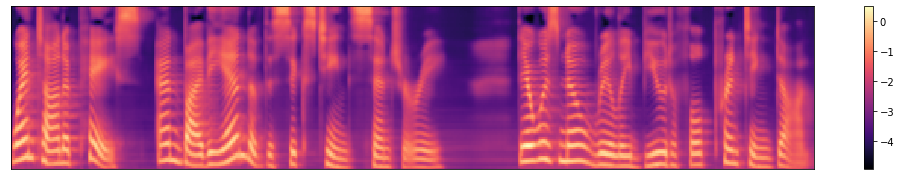

In [26]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 72:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [27]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(135680,)


0.015755414962768555


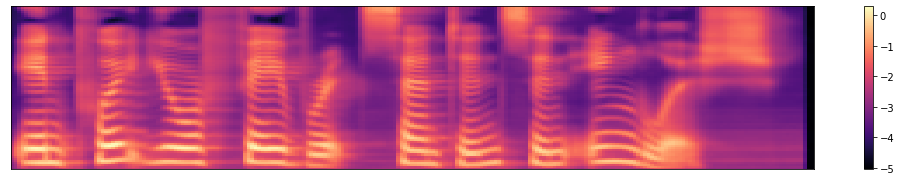

(59136,)


In [28]:
from g2p_en import G2p

g2p = G2p()

t0 = time.time()
text = "Input your favorite sentence in English."
text_array = g2p(text)
text = ""
for t in text_array:
    text += t

text_utf = text.encode()
ts = [0]
for t in text_utf:
    ts.append(t)
ts.append(0)    
utf8_values = np.array(ts)
t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
model.eval()
with torch.no_grad():
    
    samples, time_dict = model.inference(t, None, None, temperature=1.0)
    _s = samples.data.cpu().numpy()
    t1 = time.time()
    print(t1 - t0)
    plt.figure(figsize=[18, 3])
    librosa.display.specshow(_s[0])
    plt.colorbar()
    plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)